# CS470 - Introduction to Artificial Intelligence

#### Prof. Ho-Jin Choi
#### School of Computing, KAIST
---

## Information
**Please write your student ID and name here!**
- Student ID: 20180702
- Name: 추승우

---

## Homework #1: Dog and Cat Breed Identification

In this assignment, you are going to train a convolutional neural network to classify images of dog and cats as their breeds. Please follow the steps below to continue this assignment.

### Guidelines
Copy this example to your Google Colab and edit it to complete your assignment. We should be able to reproduce your results using your code and pre-trained model. Please double-check if your code runs without error properly. Submissions failed to run or reproduce the results will get a substantial penalty.

### Extra points
TAs will rank the submissions based on the test accuracy and assign extra points according to the rank. (The baseline accuracy is roughly 85%.)
 
If you improve your model's accuracy using various techniques (e.g., more stacking layer, early stopping, etc.), then please write how to improve into the block at the bottom. 

### Deliverables

- Download your Colab notebook, and your pre-trained model (i.e., checkpoint), and submit a zip file in a format: [StudentID].zip. Please double-check that you load your pre-trained model properly.
- Your assignment should be submitted through KLMS. All other submissions (e.g., via email) will not be considered as valid submissions.

### Due date

- **23:59:59 Sep 21th (Tue).**
- Late submission is allowed until 23:59:59 Sep 23th (Thu).
- Late submission will be applied 20% penalty.

In [3]:
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import os
import numpy as np
import matplotlib.pyplot as plt

# DO NOT EDIT THE FOLLOWING LINES
# THESE LINES ARE FOR REPRODUCIBILITY
np.random.seed(1)
tf.random.set_seed(1)

### 1. Load the Oxford-IIIT Pet dataset
In this assignment, you will use the Oxford-IIIT pet dataset which contains 37 category pet images with roughly 200 images for each class. 

![Oxford-IIIT Pet Dataset](https://github.com/keai-kaist/CS492F-Spring/blob/master/Assignments/Homework%201/images/oxford-iiit-pet.png?raw=true)

Please note that the images have large variations in scale, pose and lighting. Let's import and load the Oxford-IIIT pet dataset using TensorFlow Datasets:

In [2]:
import tensorflow_datasets as tfds

labels = [
    'abyssinian', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound',
    'beagle', 'bengal', 'birman', 'bombay', 'boxer', 'british_shorthair', 'chihuahua',
    'egyptian_mau', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired',
    'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'maine_coon',
    'miniature_pinscher', 'newfoundland', 'persian', 'pomeranian', 'pug', 'ragdoll',
    'russian_blue', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'siamese',
    'sphynx', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier',
]


(raw_train, raw_validation, raw_test), metadata = tfds.load('oxford_iiit_pet',
                                                           split=['train[:80%]', 'train[80%:]', 'test'],
                                                           with_info=True,
                                                           as_supervised=True)

print(len(raw_train))
print(len(raw_validation))
print(len(raw_test))
print(raw_train)
print(raw_validation)
print(raw_test)
get_label_name = metadata.features['label']
print(get_label_name)

2944
736
3669
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
ClassLabel(shape=(), dtype=tf.int64, num_classes=37)


Let's visualize what some of these images and their corresponding training labels look like.

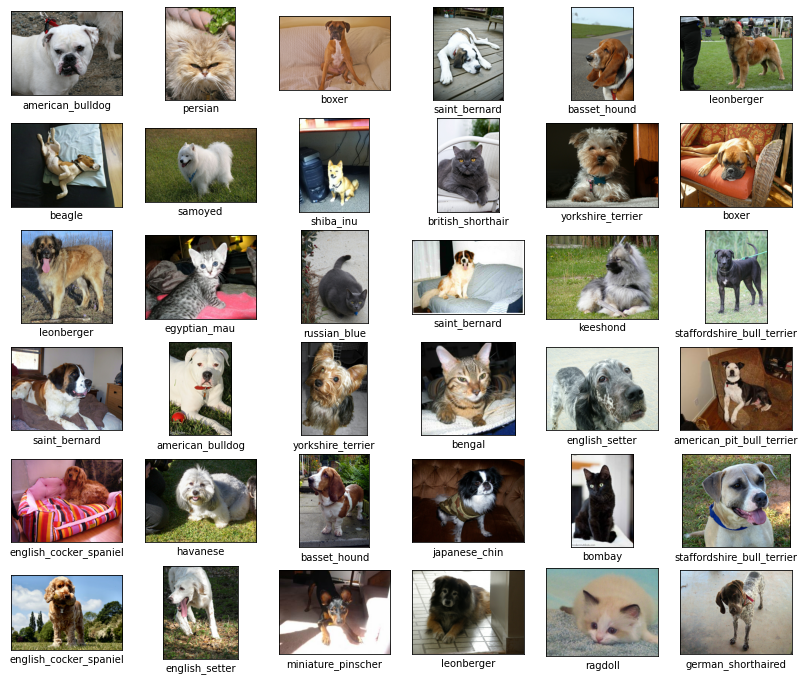

In [3]:
plt.figure(figsize=(14, 12))

for index, (image, label) in enumerate(raw_validation.take(36)):
    plt.subplot(6, 6, index + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image)
    plt.xlabel(labels[label.numpy()])

### 2. Preprocess the dataset

#### Problem 1
Define a function to preprocess the dataset. The function should **scale the input channels** to a range of [-1, 1] and **resize the images** to a fixed size, `IMAGE_SIZE`.

In [4]:
IMAGE_SIZE = 224

# TODO: Define a function to preprocess the dataset. 
#       The function should scale the input channels to a range of [-1, 1] and 
#                           resize the images to a fixed size, IMAGE_SIZE
### START CODE HERE ###
def preprocess(image, label):
    # Cast the image vector as tf.float32
    image = tf.cast(image, tf.float32)
    # Rescale the input channels to a range of [-1, 1]
    image = (image / 127.5) - 1
    # Resize the images to a fixes input size
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    # One-hot encoding
    label = tf.one_hot(label, 37)
    return image, label
### END CODE HERE ###

#### Problem 2
Apply the defined preprocessing function to `raw_train` and `raw_test`. Then, shuffle the dataset and combine them into batches.

In [5]:
BATCH_SIZE = 256
SHUFFLE_BUFFER_SIZE = 1024

# TODO: Apply the defined preprocessing function to `raw_train` and `raw_test`
#       Then, shuffle the dataset and combine them into batches
### START CODE HERE ###
train = raw_train.map(preprocess)
validation = raw_validation.map(preprocess)
test = raw_test.map(preprocess)
print(train)
print(validation)

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)
image_batch, label_batch = next(iter(train_batches.take(1)))
print(image_batch.shape)
print(label_batch.shape)
### END CODE HERE ###

<MapDataset shapes: ((224, 224, 3), (37,)), types: (tf.float32, tf.float32)>
<MapDataset shapes: ((224, 224, 3), (37,)), types: (tf.float32, tf.float32)>
(256, 224, 224, 3)
(256, 37)


### 3. Build the model
In this assignment, we are going to train the convolutional neural network using transfer learning.

#### Problem 3
Load `InceptionV3` model without the final classification layer using `tf.keras.applications.InceptionV3`. Then, freeze the model to prevent it from being trained.

In [6]:
# TODO: Load InceptionV3 model without the final classification layer
#       Then, freeze the model to prevent it from being trained
### START CODE HERE ###
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE, include_top=False, weights='imagenet', classes=37)
feature_batch = base_model(image_batch)
print(image_batch.shape,  '->', feature_batch.shape)
base_model.trainable = False
base_model.summary()
### END CODE HERE ###

(256, 224, 224, 3) -> (256, 5, 5, 2048)
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________

#### Problem 4
Define a convolutional neural network using the loaded `InceptionV3` to classify images of dogs and cats as their breeds. Then, compile your model with appropriate parameters.

In [7]:
# TODO: Define a convolutional neural network using the loaded InceptionV3
#       Then, compile your model with appropriate parameters
### START CODE HERE ###
model = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal"),
                             tf.keras.layers.RandomRotation(0.1),
                             tf.keras.layers.RandomZoom(0.1),
                             base_model,
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.GlobalAveragePooling2D(),
                             tf.keras.layers.Dense(37, activation='softmax')])

learning_rate = 0.0001
# - optimizer: RMSprop
# - loss: categorical_crossentropy
# - metrics: accuracy
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics='accuracy'
)


# loss0, accuracy0 = model.evaluate(test_batches, steps=10)
# print("initial loss: {:.2f}".format(loss0))
# print("initial accuracy: {:.2f}".format(accuracy0))
# print(model.metrics_names)
### END CODE HERE ###

### 4. Train the model

#### Problem 5
Now, train the model at least 10 epochs.

Epoch 1/35
12/12 [==============================] - 16s 1s/step - loss: 3.7033 - accuracy: 0.0543 - val_loss: 3.2776 - val_accuracy: 0.1345
Epoch 2/35
12/12 [==============================] - 6s 458ms/step - loss: 3.1296 - accuracy: 0.1756 - val_loss: 2.8247 - val_accuracy: 0.3084
Epoch 3/35
12/12 [==============================] - 6s 454ms/step - loss: 2.7057 - accuracy: 0.3312 - val_loss: 2.4495 - val_accuracy: 0.4348
Epoch 4/35
12/12 [==============================] - 6s 456ms/step - loss: 2.3585 - accuracy: 0.4524 - val_loss: 2.1162 - val_accuracy: 0.5408
Epoch 5/35
12/12 [==============================] - 6s 462ms/step - loss: 2.0386 - accuracy: 0.5520 - val_loss: 1.8283 - val_accuracy: 0.6264
Epoch 6/35
12/12 [==============================] - 6s 457ms/step - loss: 1.7657 - accuracy: 0.6345 - val_loss: 1.5837 - val_accuracy: 0.6875
Epoch 7/35
12/12 [==============================] - 6s 450ms/step - loss: 1.5700 - accuracy: 0.6749 - val_loss: 1.3809 - val_accuracy: 0.7323
Epoch 8/

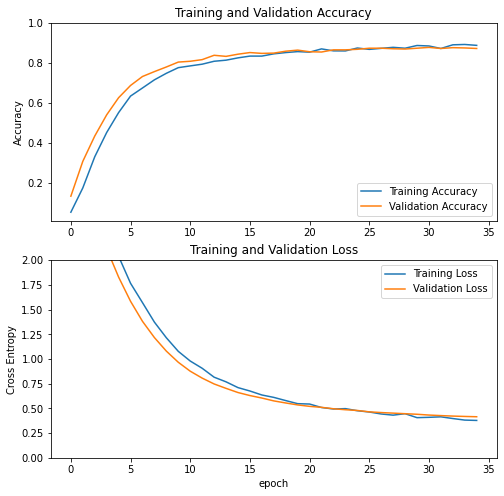

In [8]:
# TODO: Train the model at leat 10 epochs
### START CODE HERE ###
initial_epochs = 35

# Train the model
history = model.fit(
    train_batches,
    epochs=initial_epochs,
    validation_data=validation_batches,
)
model.summary()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()
### END CODE HERE ###

#### Problem 6
To fine-tune the model, unfreeze the top layers of the model. Please note that you should carefully choose layers to be frozen. Then, compile the model again with appropriate parameters.

In [9]:
# TODO: Unfreeze the top layers of the model
#       Compile the model with appropriate parameters
### START CODE HERE ###
base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 220

# TODO: Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
### END CODE HERE ###

Number of layers in the base model:  311


#### Problem 7
Fine-tune the model at least 10 epochs.

Epoch 36/47
12/12 [==============================] - 16s 763ms/step - loss: 1.0199 - accuracy: 0.8278 - val_loss: 0.3885 - val_accuracy: 0.8899
Epoch 37/47
12/12 [==============================] - 7s 569ms/step - loss: 0.7968 - accuracy: 0.8658 - val_loss: 0.3823 - val_accuracy: 0.8845
Epoch 38/47
12/12 [==============================] - 8s 572ms/step - loss: 0.6909 - accuracy: 0.8849 - val_loss: 0.3773 - val_accuracy: 0.8859
Epoch 39/47
12/12 [==============================] - 7s 567ms/step - loss: 0.6217 - accuracy: 0.8804 - val_loss: 0.3694 - val_accuracy: 0.8872
Epoch 40/47
12/12 [==============================] - 8s 574ms/step - loss: 0.5559 - accuracy: 0.8937 - val_loss: 0.3641 - val_accuracy: 0.8967
Epoch 41/47
12/12 [==============================] - 8s 580ms/step - loss: 0.5049 - accuracy: 0.9035 - val_loss: 0.3601 - val_accuracy: 0.8954
Epoch 42/47
12/12 [==============================] - 7s 571ms/step - loss: 0.4624 - accuracy: 0.9049 - val_loss: 0.3548 - val_accuracy: 0.895

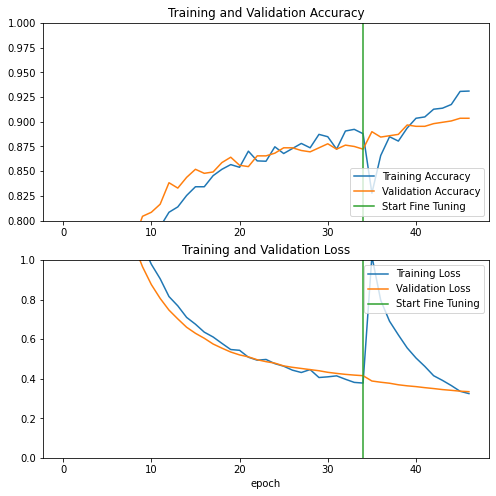

In [10]:
# TODO: Fine-tune the model at least 10 epochs
### START CODE HERE ###
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate / 10),
    metrics='accuracy'
)
fine_tune_epochs = 12
total_epochs =  initial_epochs + fine_tune_epochs

history_fine_tuned = model.fit(
    train_batches,
     epochs=total_epochs,
     initial_epoch=initial_epochs,
     validation_data=validation_batches)

history_dict = history_fine_tuned.history
print(history_dict.keys())
acc += history_fine_tuned.history['accuracy']
val_acc += history_fine_tuned.history['val_accuracy']

loss += history_fine_tuned.history['loss']
val_loss += history_fine_tuned.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()
### END CODE HERE ###

### 4. Evaluate accuracy

#### Problem 8
Evaluate the trained model using test dataset and print the test accuracy of the model.

In [5]:
# TODO: Evaluate the model using test dataset
### START CODE HERE ###\

model_load = tf.keras.models.load_model('47_1.40474e-01.h5')
loss_test, accuracy_test = model.evaluate(test_batches, steps=10)
print("test loss: {:.2f}".format(loss_test))
print("test accuracy: {:.2f}".format(accuracy_test))
### END CODE HERE ###

OSError: SavedModel file does not exist at: 47_1.40474e-01.h5\{saved_model.pbtxt|saved_model.pb}

### 5. How to improve

If you have improved the performance of your model, please fill in this block.

Dropout, early stop, preprocessing layers
